In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '120-efficientnetb4'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [ ]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
# from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

SEED = 42
seed_everything(SEED)
warnings.filterwarnings('ignore')

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 32,
  "EPOCHS": 12,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 5,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'EfficientNetB4',
  "BASE_MODEL_WEIGHTS": 'imagenet',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB4',
 'BASE_MODEL_WEIGHTS': 'imagenet',
 'BATCH_SIZE': 32,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 12,
 'ES_PATIENCE': 5,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'WIDTH': 256}

# Load data

In [8]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
train = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-4448f537f295258dbdda5d31f52f1be1fb3b28299050f00020165137'
GCS_2019_PATH = 'gs://kds-809fedd13d0b3052396b2c6de7466d3f45a8b07c98c0412fdba287ed'
GCS_MALIGNANT_PATH = 'gs://kds-8575da0d421fa5470ff18825048c143d29ca3454d015e135a0a3fbcc'

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
#@title
def data_augment(image):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, config['HEIGHT'], shear=5.)
        else:
            image = transform_shear(image, config['HEIGHT'], shear=-5.)
    
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, config['HEIGHT'], rotation=45.)
        else:
            image = transform_rotation(image, config['HEIGHT'], rotation=-45.)

    if p_crop > .5:
        image = data_augment_crop(image)

    if p_rotate > .2:
        image = data_augment_rotate(image)
        
    image = data_augment_spatial(image)
    
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    
    if p_cutout > .7:
        image = data_augment_cutout(image)
    
    return image


def data_augment_tta(image):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, config['HEIGHT'], rotation=45.)
        else:
            image = transform_rotation(image, config['HEIGHT'], rotation=-45.)

    if p_crop > .5:
        image = data_augment_crop(image)

    if p_rotate > .2:
        image = data_augment_rotate(image)
        
    image = data_augment_spatial(image)
    
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    
    return image


def data_augment_spatial(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    crop_size = tf.random.uniform([], int(config['HEIGHT']*.7), config['HEIGHT'], dtype=tf.int32)
    
    if p_crop > .5:
        image = tf.image.random_crop(image, size=[crop_size, crop_size, config['CHANNELS']])
    else:
        if p_crop > .4:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .2:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
    
    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_cutout(image, min_mask_size=(int(config['HEIGHT'] * .1), int(config['HEIGHT'] * .1)), 
                        max_mask_size=(int(config['HEIGHT'] * .125), int(config['HEIGHT'] * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

## Auxiliary functions

In [10]:
#@title
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0
 
def prepare_image(img, augment=None, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = augment(img)
                      
    img = tf.reshape(img, [dim, dim, 3])
            
    return img

def get_dataset(files, augment=None, shuffle=False, repeat=False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

## Learning rate scheduler

In [11]:
#@title
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * config['BATCH_SIZE']
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

# Model

In [12]:
#@title
# Initial bias
pos = len(train[train['target'] == 1]) * 2 + 1627 + 580
neg = len(train[train['target'] == 0]) + 8388
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(train)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
3375
40930
[-2.49546797]
Class weight
{0: 0.40466650378695335, 1: 4.907555555555556}


In [16]:
def model_fn(input_shape=(256, 256, 3)):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB4(input_shape=input_shape, 
                                    weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid', name='output', 
                    #  bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
                     )(x)

    model = Model(inputs=input_image, outputs=output)

    opt = optimizers.Adam(learning_rate=0.001)
    loss = losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(optimizer=opt, loss=loss,metrics=['AUC'])

    return model

# Training

In [17]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = []; history_list = []; oof_pred_last = []
preds = np.zeros((len(test), 1))
preds_last = np.zeros((len(test), 1))

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # CREATE TRAIN AND VALIDATION SUBSETS
    TRAINING_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec' % x for x in idxT])
    # Add external data
    # TRAINING_FILENAMES += tf.io.gfile.glob([GCS_2019_PATH + '/train%.2i*.tfrec' % (x*2+1) for x in idxT]) # 2019 data
    TRAINING_FILENAMES += tf.io.gfile.glob([GCS_2019_PATH + '/train%.2i*.tfrec' % (x*2) for x in idxT]) # 2018 data
    # Add extra malignant data
    TRAINING_FILENAMES += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % x for x in idxT]) # 2020 data
    # TRAINING_FILENAMES += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % ((x*2+1)+30) for x in idxT]) # 2019 data
    TRAINING_FILENAMES += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % ((x*2)+30) for x in idxT]) # 2018 data
    TRAINING_FILENAMES += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % (x+15) for x in idxT]) # new data

    np.random.shuffle(TRAINING_FILENAMES)
    files_valid = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxV])
    TEST_FILENAMES = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))
    ct_valid = count_data_items(files_valid)
    ct_test = count_data_items(TEST_FILENAMES)
    VALID_STEPS = config['TTA_STEPS'] * ct_valid/config['BATCH_SIZE']/4/REPLICAS
    TEST_STEPS = config['TTA_STEPS'] * ct_test/config['BATCH_SIZE']/4/REPLICAS
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

    model_path_best_auc = f'{MODEL_BASE_PATH}model_{fold}_auc.h5'
    model_path_best_loss = f'{MODEL_BASE_PATH}model_{fold}_loss.h5'
    # model_path_last = f'{MODEL_BASE_PATH}model_{fold}_last.h5'
    checkpoint_auc = ModelCheckpoint(model_path_best_auc, monitor='val_auc', mode='max', save_best_only=True,
                                     save_weights_only=True, verbose=0)
    checkpoint_loss = ModelCheckpoint(model_path_best_loss, monitor='val_loss', mode='min', save_best_only=True,
                                      save_weights_only=True, verbose=0)
   
    # TRAIN
    history = model.fit(get_dataset(TRAINING_FILENAMES, augment=data_augment, shuffle=True, repeat=True,
                                    dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']), 
                        validation_data=get_dataset(files_valid,augment=None,shuffle=False,
                                                    repeat=False,dim=config['HEIGHT']), 
                        steps_per_epoch=count_data_items(TRAINING_FILENAMES)/config['BATCH_SIZE']//REPLICAS, 
                        callbacks=[checkpoint_auc, checkpoint_loss, get_lr_callback(config['BATCH_SIZE'])], 
                        epochs=config['EPOCHS'], 
                        class_weight=class_weight,
                        verbose=2).history
    
    history_list.append(history)
    # Save last model weights
    # model.save_weights(model_path_last)

    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=None, repeat=False, dim=config['HEIGHT'],
                          labeled=True, return_image_names=True)
    oof_tar.append(np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]))
    oof_folds.append(np.ones_like(oof_tar[-1], dtype='int8')*fold)
    ds = get_dataset(files_valid, augment=None, repeat=False, dim=config['HEIGHT'],
                    labeled=False, return_image_names=True)
    oof_names.append(np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))

    # Load best model weights (AUC)
    model.load_weights(model_path_best_auc)
    
    # PREDICT OOF USING TTA (AUC)
    print('Predicting OOF with TTA (AUC)...')
    ds_valid = get_dataset(files_valid, labeled=False, return_image_names=False, augment=data_augment_tta,
                          repeat=True, shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_valid, steps=VALID_STEPS, verbose=2)[:config['TTA_STEPS']*ct_valid,]
    oof_pred_last.append(np.mean(pred.reshape((ct_valid, config['TTA_STEPS']), order='F'),axis=1))

    # PREDICT TEST USING TTA (AUC)
    print('Predicting Test with TTA (AUC)...')
    ds_test = get_dataset(TEST_FILENAMES, labeled=False, return_image_names=False, augment=data_augment_tta,
                          repeat=True, shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_test, steps=TEST_STEPS, verbose=2)[:config['TTA_STEPS']*ct_test,]
    preds_last[:,0] += np.mean(pred.reshape((ct_test, config['TTA_STEPS']), order='F'), axis=1) / config['N_USED_FOLDS']

    # Load best model weights (Loss)
    model.load_weights(model_path_best_loss)
    
    # PREDICT OOF USING TTA (Loss)
    print('Predicting OOF with TTA (Loss)...')
    ds_valid = get_dataset(files_valid, labeled=False, return_image_names=False, augment=data_augment,
                          repeat=True, shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_valid, steps=VALID_STEPS, verbose=2)[:config['TTA_STEPS']*ct_valid,]
    oof_pred.append(np.mean(pred.reshape((ct_valid, config['TTA_STEPS']), order='F'), axis=1))
    
    # PREDICT TEST USING TTA (Loss)
    print('Predicting Test with TTA (Loss)...')
    ds_test = get_dataset(TEST_FILENAMES, labeled=False, return_image_names=False, augment=data_augment,
                          repeat=True, shuffle=False, dim=config  ['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_test, steps=TEST_STEPS, verbose=2)[:config['TTA_STEPS']*ct_test,]
    preds[:,0] += np.mean(pred.reshape((ct_test, config['TTA_STEPS']), order='F'), axis=1) / config['N_USED_FOLDS']

    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1], oof_pred[-1])
    auc_last = roc_auc_score(oof_tar[-1], oof_pred_last[-1])
    oof_val.append(np.max(history['val_auc']))
    print(f'#### FOLD {fold+1} OOF AUC = {oof_val[-1]:.3f}, with TTA (Loss) = {auc:.3f}, with TTA (AUC) = {auc_last:.3f}')

INFO:tensorflow:Initializing the TPU system: grpc://10.16.55.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.16.55.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]
Epoch 1/12
151/151 - 79s - auc: 0.5855 - loss: 0.6051 - val_auc: 0.6028 - val_loss: 0.6049 - lr: 5.0000e-06
Epoch 2/12
151/151 - 61s - auc: 0.8555 - loss: 0.4309 - val_auc: 0.8532 - val_loss: 0.2773 - lr: 6.8000e-05
Epoch 3/12
151/151 - 57s - auc: 0.9023 - loss: 0.3679 - val_auc: 0.8878 - val_loss: 0.2956 - lr: 1.3100e-04
Epoch 4/12
151/151 - 58s - auc: 0.9193 - loss: 0.3433 - val_auc: 0.8957 - val_loss: 0.3465 - lr: 1.9400e-04
Epoch 5/12
151/151 - 54s - auc: 0.9326 - loss: 0.3188 - val_auc: 0.8952 - val_loss: 0.2793 - lr: 2.5700e-04
Epoch 6/12
151/151 - 58s - auc: 0.9412 - loss: 0.3070 - val_auc: 0.8966 - val_loss: 0.3605 - lr: 3.2000e-04
Epoch 7/12
151/151 - 58s - auc: 0.9511 - loss: 0.2840 - val_auc: 0.9026 - val_loss: 0.4030 - lr: 2.5620e-04
Epoch 8/12
151/151 - 58s - auc: 0.9576 - loss: 0.2725 - val_auc: 0.9050 - val_loss: 0.3120 - lr: 2.0516e-04
Epoch 9/12
151/151 - 54s - auc: 0.9668 - loss: 0.2492 - val_auc:

INFO:tensorflow:Initializing the TPU system: grpc://10.16.55.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.16.55.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 2
TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]
Epoch 1/12
151/151 - 79s - auc: 0.6203 - loss: 0.6086 - val_auc: 0.5918 - val_loss: 0.6887 - lr: 5.0000e-06
Epoch 2/12
151/151 - 61s - auc: 0.8553 - loss: 0.4298 - val_auc: 0.8429 - val_loss: 0.3031 - lr: 6.8000e-05
Epoch 3/12
151/151 - 57s - auc: 0.8982 - loss: 0.3751 - val_auc: 0.8508 - val_loss: 0.3415 - lr: 1.3100e-04
Epoch 4/12
151/151 - 57s - auc: 0.9175 - loss: 0.3443 - val_auc: 0.8289 - val_loss: 0.2978 - lr: 1.9400e-04
Epoch 5/12
151/151 - 58s - auc: 0.9296 - loss: 0.3269 - val_auc: 0.8635 - val_loss: 0.2991 - lr: 2.5700e-04
Epoch 6/12
151/151 - 58s - auc: 0.9399 - loss: 0.3079 - val_auc: 0.8745 - val_loss: 0.3615 - lr: 3.2000e-04
Epoch 7/12
151/151 - 61s - auc: 0.9494 - loss: 0.2894 - val_auc: 0.8749 - val_loss: 0.2608 - lr: 2.5620e-04
Epoch 8/12
151/151 - 61s - auc: 0.9596 - loss: 0.2692 - val_auc: 0.8839 - val_loss: 0.2458 - lr: 2.0516e-04
Epoch 9/12
151/151 - 57s - auc: 0.9660 - loss: 0.2524 - val_auc:

INFO:tensorflow:Initializing the TPU system: grpc://10.16.55.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.16.55.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 3
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]
Epoch 1/12
151/151 - 79s - auc: 0.6077 - loss: 0.6068 - val_auc: 0.6217 - val_loss: 0.6463 - lr: 5.0000e-06
Epoch 2/12
151/151 - 61s - auc: 0.8526 - loss: 0.4354 - val_auc: 0.8624 - val_loss: 0.2913 - lr: 6.8000e-05
Epoch 3/12
151/151 - 58s - auc: 0.8978 - loss: 0.3756 - val_auc: 0.8948 - val_loss: 0.3135 - lr: 1.3100e-04
Epoch 4/12
151/151 - 58s - auc: 0.9150 - loss: 0.3509 - val_auc: 0.8943 - val_loss: 0.2334 - lr: 1.9400e-04
Epoch 5/12
151/151 - 57s - auc: 0.9293 - loss: 0.3271 - val_auc: 0.9089 - val_loss: 0.2646 - lr: 2.5700e-04
Epoch 6/12
151/151 - 54s - auc: 0.9389 - loss: 0.3091 - val_auc: 0.8964 - val_loss: 0.2348 - lr: 3.2000e-04
Epoch 7/12
151/151 - 62s - auc: 0.9487 - loss: 0.2919 - val_auc: 0.9092 - val_loss: 0.2031 - lr: 2.5620e-04
Epoch 8/12
151/151 - 54s - auc: 0.9561 - loss: 0.2750 - val_auc: 0.9025 - val_loss: 0.2050 - lr: 2.0516e-04
Epoch 9/12
151/151 - 54s - auc: 0.9640 - loss: 0.2587 - val_auc:

INFO:tensorflow:Initializing the TPU system: grpc://10.16.55.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.16.55.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 4
TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]
Epoch 1/12
151/151 - 84s - auc: 0.6219 - loss: 0.6028 - val_auc: 0.6027 - val_loss: 0.5691 - lr: 5.0000e-06
Epoch 2/12
151/151 - 61s - auc: 0.8532 - loss: 0.4304 - val_auc: 0.8328 - val_loss: 0.2603 - lr: 6.8000e-05
Epoch 3/12
151/151 - 58s - auc: 0.8982 - loss: 0.3739 - val_auc: 0.8871 - val_loss: 0.3087 - lr: 1.3100e-04
Epoch 4/12
151/151 - 54s - auc: 0.9166 - loss: 0.3486 - val_auc: 0.8850 - val_loss: 0.2655 - lr: 1.9400e-04
Epoch 5/12
151/151 - 62s - auc: 0.9262 - loss: 0.3307 - val_auc: 0.8956 - val_loss: 0.2540 - lr: 2.5700e-04
Epoch 6/12
151/151 - 54s - auc: 0.9408 - loss: 0.3053 - val_auc: 0.8781 - val_loss: 0.2797 - lr: 3.2000e-04
Epoch 7/12
151/151 - 61s - auc: 0.9496 - loss: 0.2876 - val_auc: 0.9081 - val_loss: 0.2533 - lr: 2.5620e-04
Epoch 8/12
151/151 - 57s - auc: 0.9590 - loss: 0.2696 - val_auc: 0.8800 - val_loss: 0.2241 - lr: 2.0516e-04
Epoch 9/12
151/151 - 54s - auc: 0.9654 - loss: 0.2544 - val_auc:

INFO:tensorflow:Initializing the TPU system: grpc://10.16.55.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.16.55.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 5
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]
Epoch 1/12
150/150 - 84s - auc: 0.6497 - loss: 0.5740 - val_auc: 0.6285 - val_loss: 0.6434 - lr: 5.0000e-06
Epoch 2/12
150/150 - 62s - auc: 0.8545 - loss: 0.4365 - val_auc: 0.8597 - val_loss: 0.2649 - lr: 6.8000e-05
Epoch 3/12
150/150 - 57s - auc: 0.9002 - loss: 0.3720 - val_auc: 0.9045 - val_loss: 0.2735 - lr: 1.3100e-04
Epoch 4/12
150/150 - 54s - auc: 0.9167 - loss: 0.3466 - val_auc: 0.8998 - val_loss: 0.2795 - lr: 1.9400e-04
Epoch 5/12
150/150 - 62s - auc: 0.9304 - loss: 0.3256 - val_auc: 0.9136 - val_loss: 0.2450 - lr: 2.5700e-04
Epoch 6/12
150/150 - 54s - auc: 0.9393 - loss: 0.3100 - val_auc: 0.9005 - val_loss: 0.2768 - lr: 3.2000e-04
Epoch 7/12
150/150 - 58s - auc: 0.9485 - loss: 0.2922 - val_auc: 0.8919 - val_loss: 0.2174 - lr: 2.5620e-04
Epoch 8/12
150/150 - 54s - auc: 0.9578 - loss: 0.2706 - val_auc: 0.9069 - val_loss: 0.2257 - lr: 2.0516e-04
Epoch 9/12
150/150 - 58s - auc: 0.9636 - loss: 0.2590 - val_auc:

## Model loss graph

Fold: 1


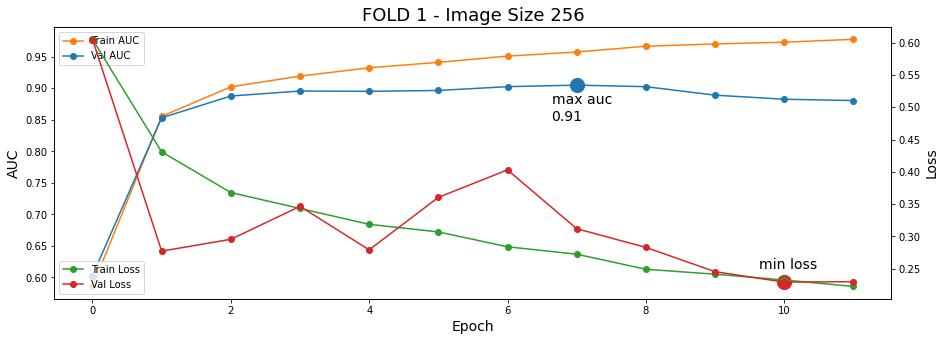

Fold: 2


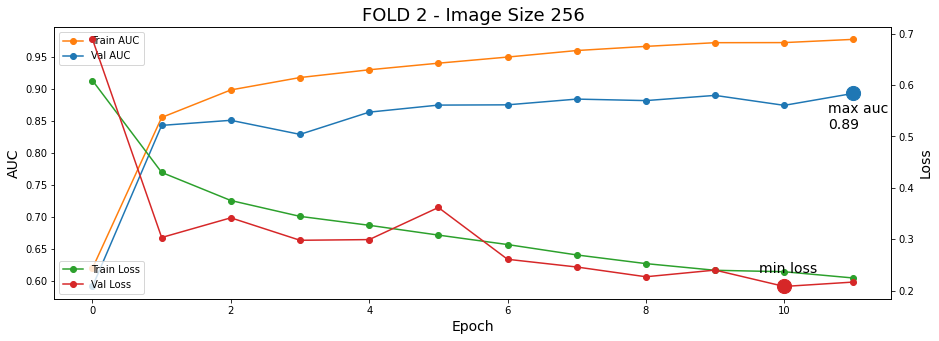

Fold: 3


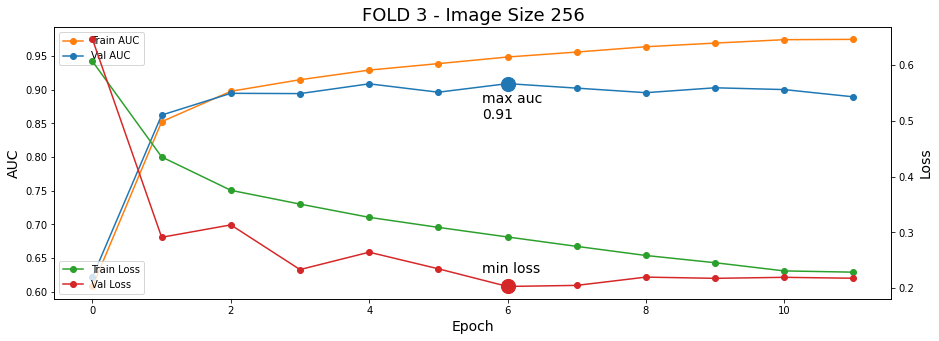

Fold: 4


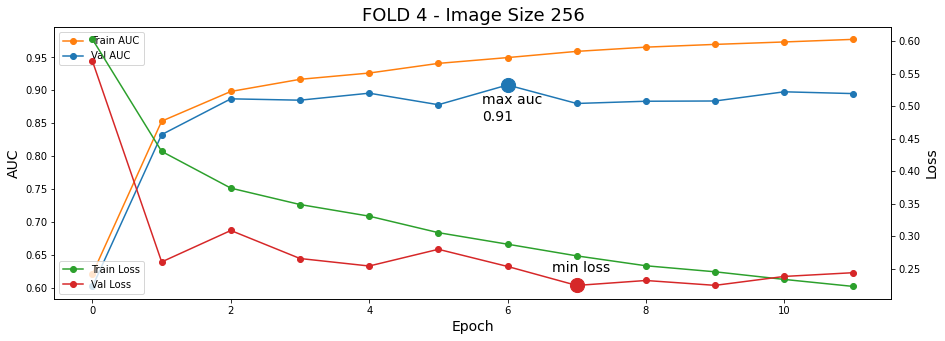

Fold: 5


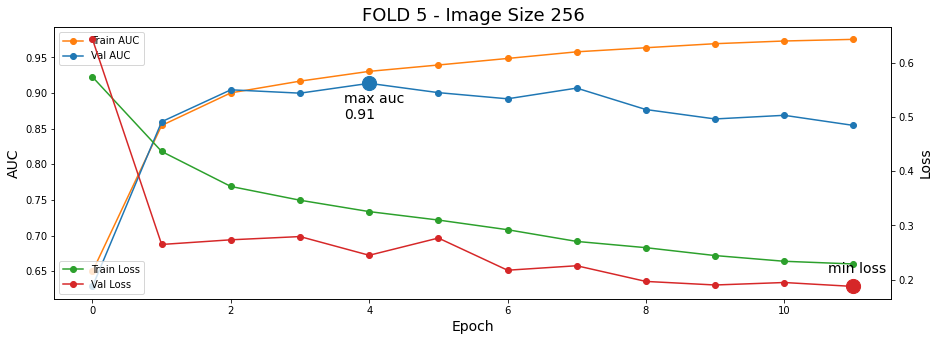

In [18]:
#@title
for n_fold, history in enumerate(history_list):
    print(f'Fold: {n_fold + 1}')
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(config['EPOCHS']), history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    plt.plot(np.arange(config['EPOCHS']), history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
    x = np.argmax(history['val_auc'])
    y = np.max(history['val_auc'])
    xdist = plt.xlim()[1] - plt.xlim()[0]
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4')
    plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC',size=14)
    plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(config['EPOCHS']), history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(config['EPOCHS']), history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin(history['val_loss'])
    y = np.min(history['val_loss'])
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728')
    plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('FOLD %i - Image Size %i' % (n_fold+1, config['HEIGHT']), size=18)
    plt.legend(loc=3)
    plt.show()

## Model loss graph aggregated

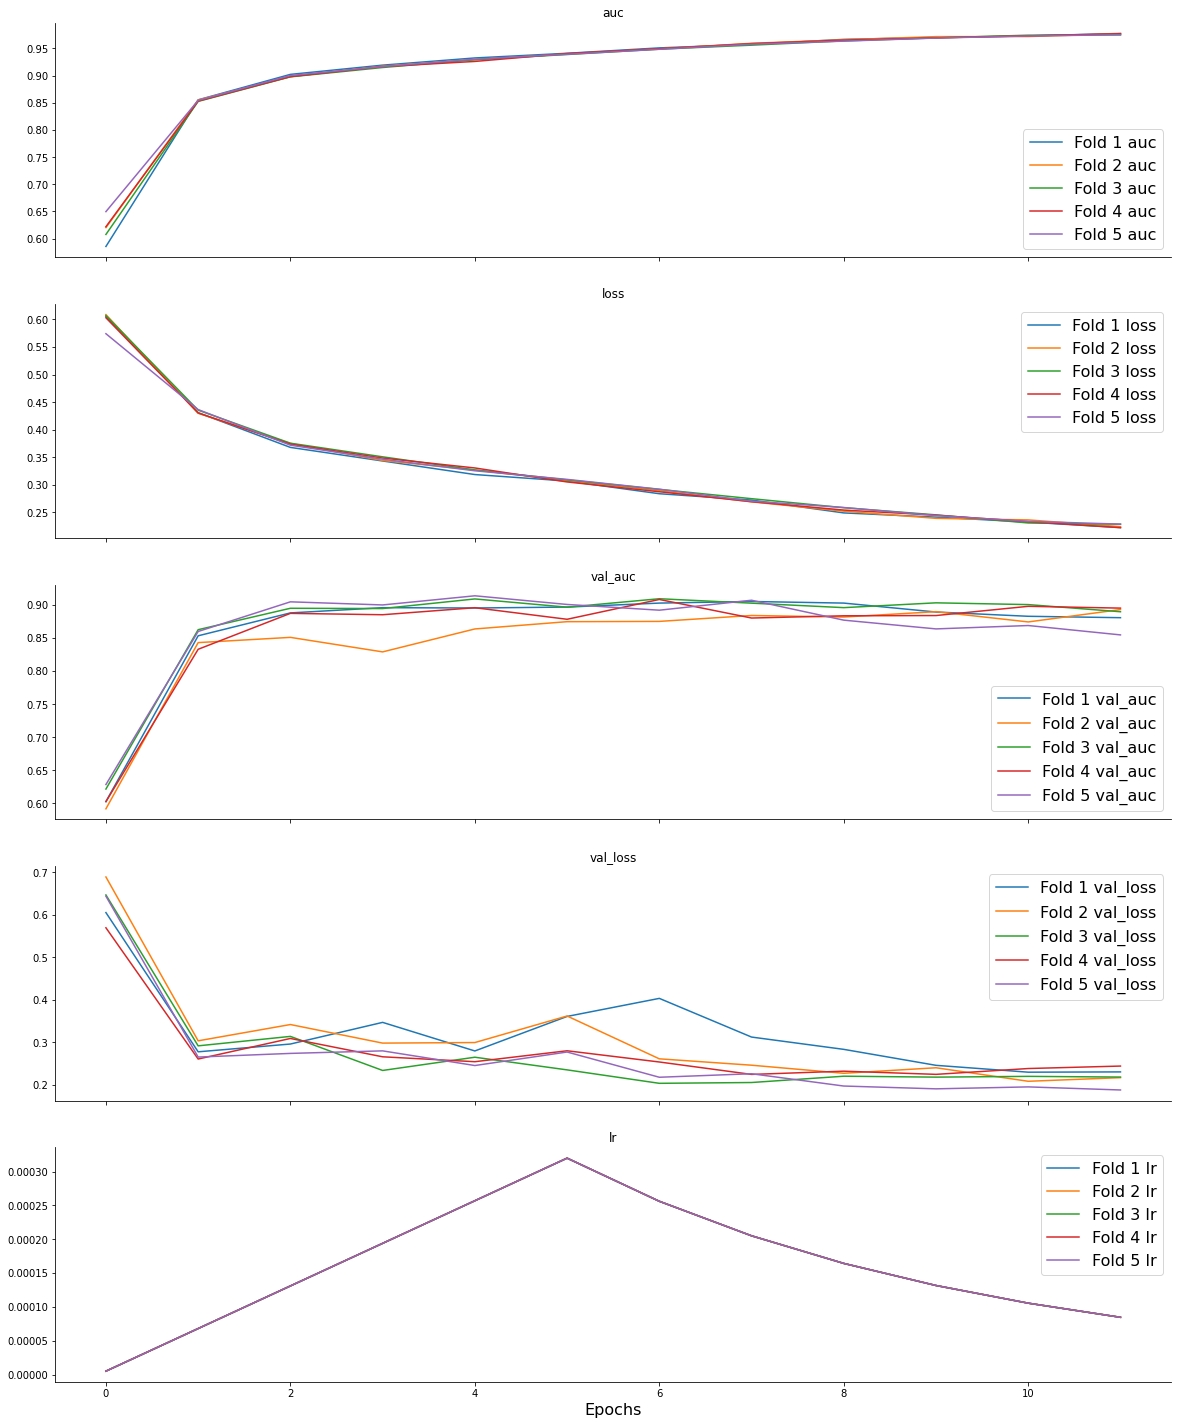

In [19]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [20]:
#@title
# COMPUTE OVERALL OOF AUC (last)
oof = np.concatenate(oof_pred_last)
true = np.concatenate(oof_tar)
names = np.concatenate(oof_names)
folds = np.concatenate(oof_folds)
auc = roc_auc_score(true, oof)
print('Overall OOF AUC with TTA (last) = %.3f' % auc)

# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred)
true = np.concatenate(oof_tar)
names = np.concatenate(oof_names)
folds = np.concatenate(oof_folds)
auc = roc_auc_score(true, oof)
print('Overall OOF AUC with TTA = %.3f' % auc)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(image_name=names, target=true, pred=oof, fold=folds))
df_oof.to_csv('oof.csv', index=False)
df_oof.head()

Overall OOF AUC with TTA (last) = 0.909
Overall OOF AUC with TTA = 0.907


,image_name,target,pred,fold
0,ISIC_2637011,0,0.054433,0
1,ISIC_0076262,0,0.041844,0
2,ISIC_0074268,0,0.009856,0
3,ISIC_0015719,0,0.005677,0
4,ISIC_0082543,0,0.009902,0


# Visualize test predictions

Test predictions 406|10576
Test predictions (last) 572|10410
Top 10 samples


,image_name,target,target_last
9905,ISIC_0052060,0.025779,0.020661
1443,ISIC_0052349,0.020841,0.019333
3120,ISIC_0058510,0.015082,0.019734
4870,ISIC_0073313,0.019608,0.016394
5494,ISIC_0073502,0.016740,0.023937
4537,ISIC_0074618,0.044054,0.118705
4819,ISIC_0076801,0.068634,0.141803
7203,ISIC_0077586,0.068828,0.068156
10897,ISIC_0082004,0.090165,0.139795
5093,ISIC_0082785,0.032234,0.050988


Top 10 positive samples


,image_name,target,target_last
2280,ISIC_0112420,0.922286,0.939882
8522,ISIC_0155983,0.660621,0.702469
1782,ISIC_0169906,0.540759,0.608175
3352,ISIC_0175798,0.640993,0.660045
9279,ISIC_0183449,0.548446,0.578562
1215,ISIC_0200120,0.792267,0.814469
2519,ISIC_0208233,0.625723,0.616445
3184,ISIC_0216447,0.569149,0.489118
9464,ISIC_0220438,0.804585,0.820487
5389,ISIC_0235501,0.506640,0.586734


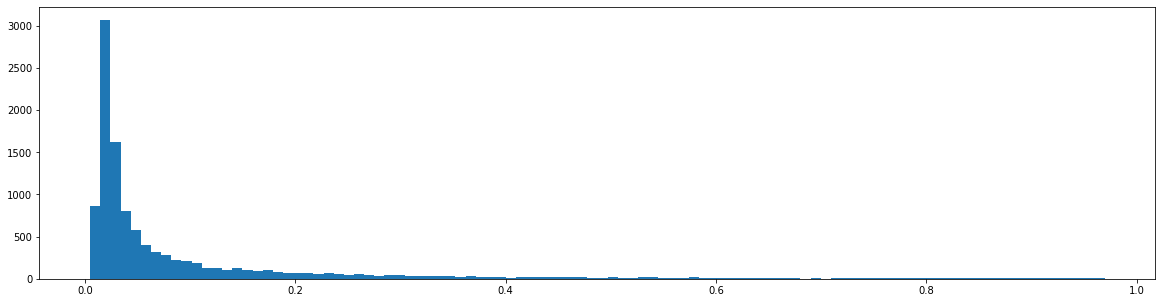

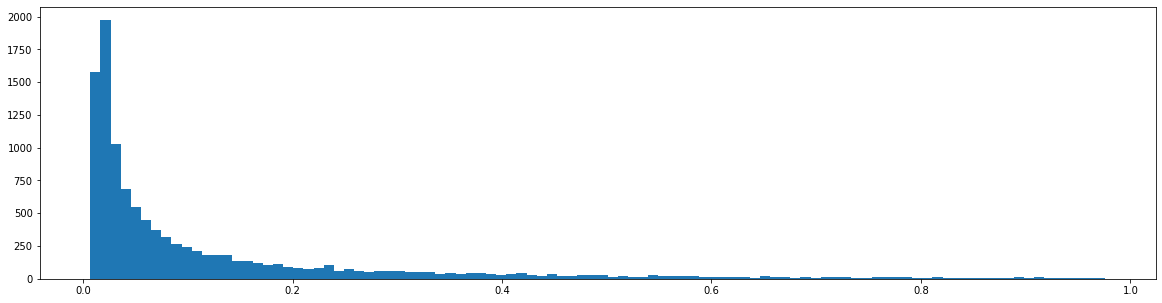

In [21]:
#@title
ds = get_dataset(TEST_FILENAMES, augment=False, repeat=False, dim=config['HEIGHT'],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())])

submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0], target_last=preds_last[:,0]))
submission = submission.sort_values('image_name')

print(f"Test predictions {len(submission[submission['target'] > .5])}|{len(submission[submission['target'] <= .5])}")
print(f"Test predictions (last) {len(submission[submission['target_last'] > .5])}|{len(submission[submission['target_last'] <= .5])}")

print('Top 10 samples')
display(submission.head(10))

print('Top 10 positive samples')
display(submission.query('target > .5').head(10))

fig = plt.subplots(figsize=(20, 5))
plt.hist(submission['target'], bins=100)
plt.show()

fig = plt.subplots(figsize=(20, 5))
plt.hist(submission['target_last'], bins=100)
plt.show()

# Test set predictions

In [22]:
#@title
submission['target_blend'] = (submission['target'] * .5) +  (submission['target_last'] * .5)
display(submission.head(10))
display(submission.describe().T)

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend
9905,ISIC_0052060,0.025779,0.020661,0.023220
1443,ISIC_0052349,0.020841,0.019333,0.020087
3120,ISIC_0058510,0.015082,0.019734,0.017408
4870,ISIC_0073313,0.019608,0.016394,0.018001
5494,ISIC_0073502,0.016740,0.023937,0.020339
4537,ISIC_0074618,0.044054,0.118705,0.081380
4819,ISIC_0076801,0.068634,0.141803,0.105219
7203,ISIC_0077586,0.068828,0.068156,0.068492
10897,ISIC_0082004,0.090165,0.139795,0.114980
5093,ISIC_0082785,0.032234,0.050988,0.041611


,count,mean,std,min,25%,50%,75%,max
target,10982.0,0.096480,0.150809,0.005119,0.020292,0.033499,0.095078,0.969611
target_last,10982.0,0.123531,0.171746,0.006906,0.021417,0.048781,0.144263,0.975588
target_blend,10982.0,0.110005,0.159820,0.006798,0.021255,0.041974,0.120047,0.971298
